首先我们来对美国的总进口数据做一些简单分析, 首先引入我们目标的数据

In [77]:
import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

df_imports = pd.read_csv(r'..\..\data\processed\Q4_IMPTOTUS_ALL.csv')

# Adjust the index to time format
df_imports['observation_date'] = pd.to_datetime(df_imports['observation_date'])
df_imports.set_index('observation_date', inplace=True)

print(df_imports.dtypes)

IMPTOTUS    float64
dtype: object


体会一下:
- 整体趋势图
- 查分图

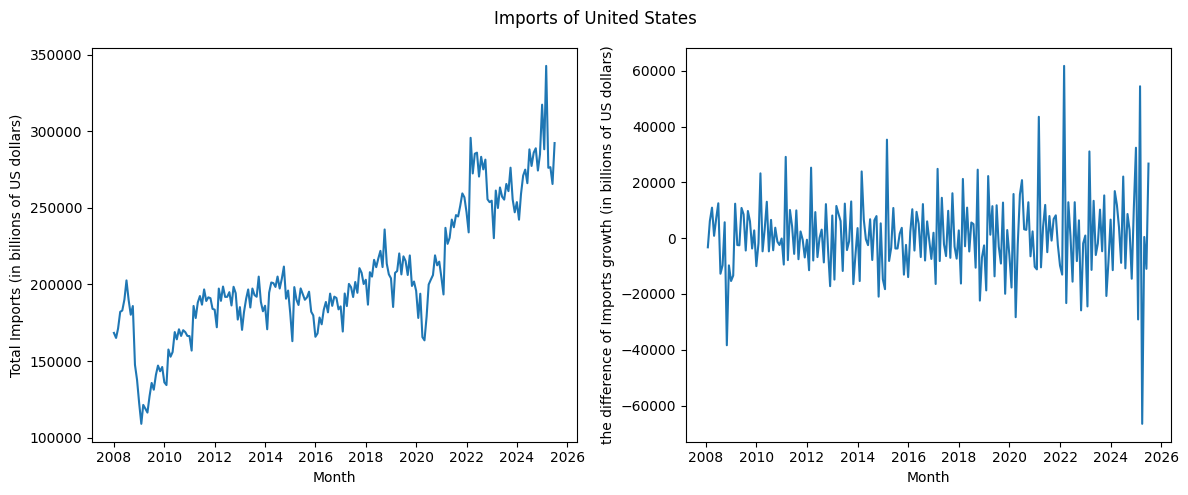

Descriptive Statistics of Differenced Imports:
count      210.000000
mean       589.974762
std      14531.210351
min     -66517.129489
25%      -8003.952381
50%       -569.000000
75%       9178.221465
max      61716.466537
Name: IMPTOTUS_DIFF, dtype: float64


In [67]:
fig, axes = plt.subplots(1,2, figsize=(12, 5))
fig.suptitle('Imports of United States')

axes[0].plot(df_imports.index,df_imports['IMPTOTUS'])
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Total Imports (in billions of US dollars)')

df_imports['IMPTOTUS_DIFF']=df_imports['IMPTOTUS'].astype(float).diff()

axes[1].plot(df_imports.index,df_imports['IMPTOTUS_DIFF'])
axes[1].set_xlabel('Month')
axes[1].set_ylabel('the difference of Imports growth (in billions of US dollars)')

plt.tight_layout()
plt.show()

# describe the differenced data
print("Descriptive Statistics of Differenced Imports:")
print(df_imports['IMPTOTUS_DIFF'].describe())

想要来估计2025美国关税对世界的影响, 首先需要关注的2018年中美关税战的影响: 还是关注一下总体趋势和差分, 和上面的进行一下对比

   observation_date     IMPTOTUS
0          20180101  37518374655
1          20180201  31628626060
2          20180301  30634211012
3          20180401  36035285844
4          20180501  39280961984
observation_date    int64
IMPTOTUS            int64
dtype: object
observation_date      int64
IMPTOTUS            float64
dtype: object
   observation_date      IMPTOTUS
0          20180101  3.751837e+10
1          20180201  3.162863e+10
2          20180301  3.063421e+10
3          20180401  3.603529e+10
4          20180501  3.928096e+10


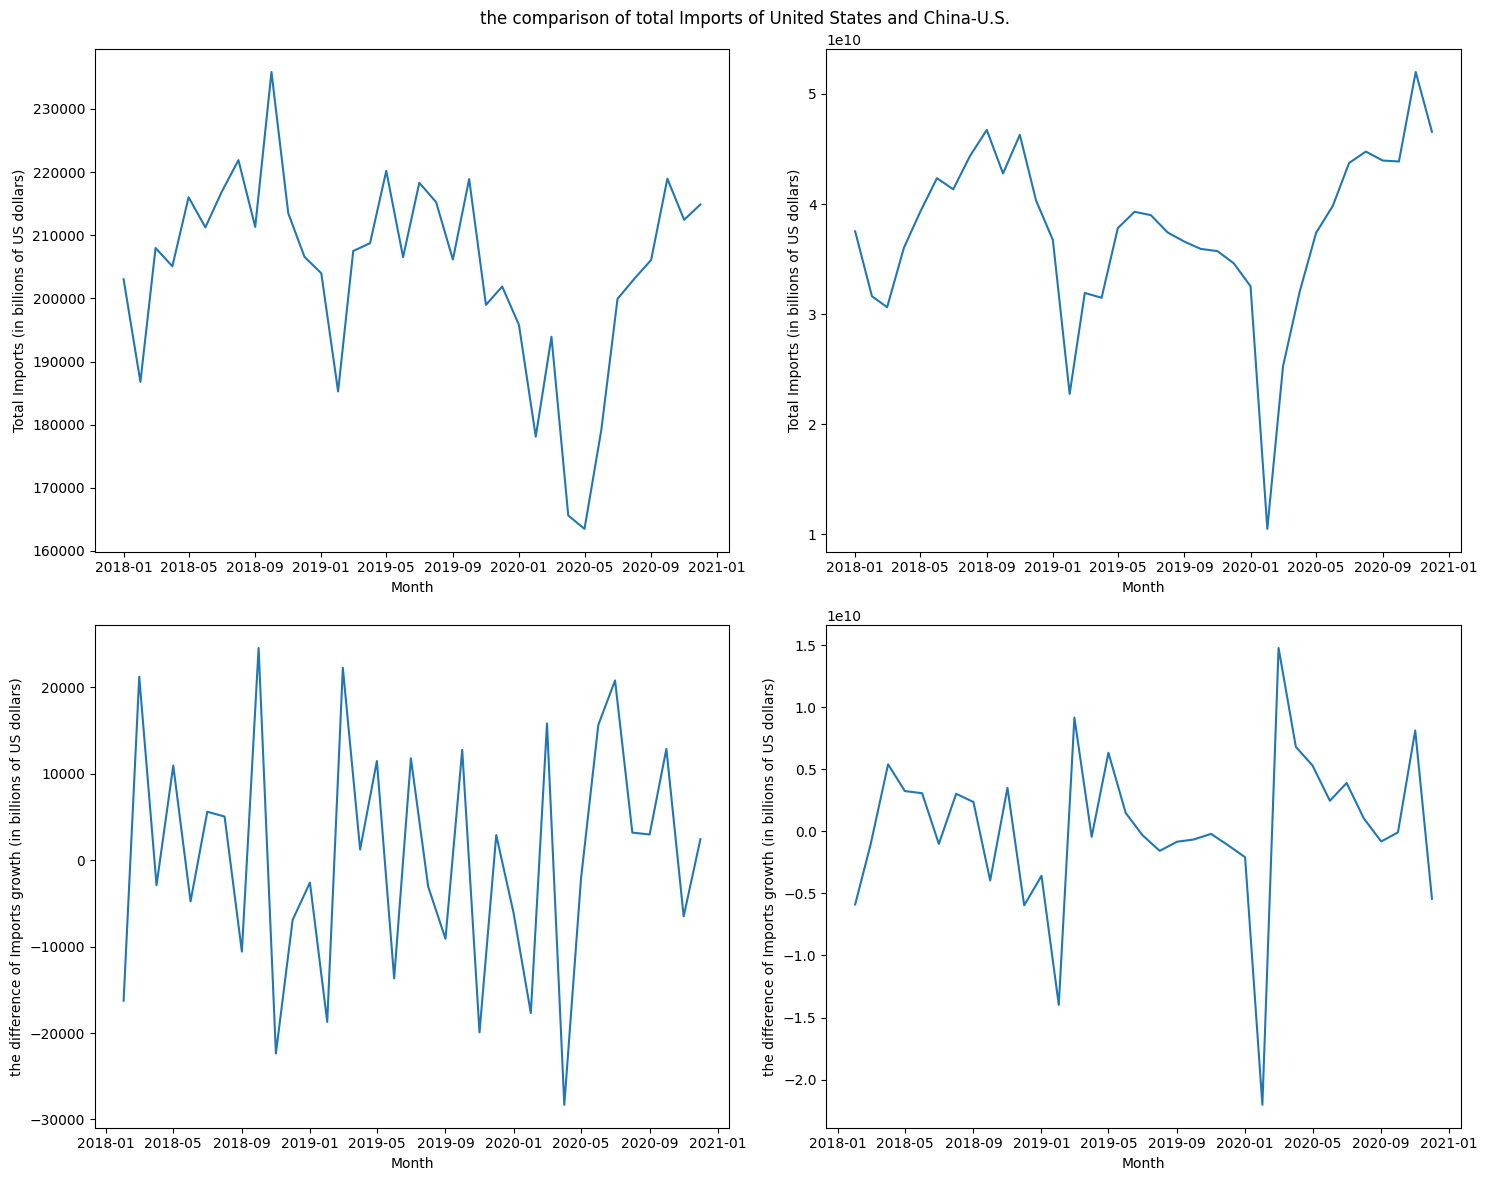

IMPTOTUS         float64
IMPTOTUS_DIFF    float64
dtype: object


In [81]:
# introduce the china-US import data of 2018 trade war

df_trade_war_2018=[
    pd.read_csv(r'..\..\data\raw\Q4\18年.csv'), 
    pd.read_csv(r'..\..\data\raw\Q4\19年.csv'), 
    pd.read_csv(r'..\..\data\raw\Q4\20年.csv')
    ]

# merge the data
df_trade_war_2018_2020=pd.DataFrame()
for df in df_trade_war_2018:
    df_trade_war_2018_2020=pd.concat([df_trade_war_2018_2020,df],axis=0)

# show the merged data
print(df_trade_war_2018_2020.head())

# grasp the useful information and adjust the index
print(df_trade_war_2018_2020.dtypes)
df_trade_war_2018_2020['IMPTOTUS']=df_trade_war_2018_2020['IMPTOTUS'].astype(float)
print(df_trade_war_2018_2020.dtypes)
print(df_trade_war_2018_2020.head())
df_trade_war_2018_2020['observation_date']=pd.to_datetime(df_trade_war_2018_2020['observation_date'], format='%Y%m%d')
df_trade_war_2018_2020.set_index('observation_date', inplace=True)
df_trade_war_2018_2020.head()

# Overall trend and difference
fig, axes = plt.subplots(2,2, figsize=(15, 12))
fig.suptitle('the comparison of total Imports of United States and China-U.S.')

axes[0, 1].plot(df_trade_war_2018_2020.index,df_trade_war_2018_2020['IMPTOTUS'])
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Total Imports (in billions of US dollars)')

df_trade_war_2018_2020['IMPTOTUS_DIFF']=df_trade_war_2018_2020['IMPTOTUS'].astype(float).diff()

axes[1, 1].plot(df_trade_war_2018_2020.index,df_trade_war_2018_2020['IMPTOTUS_DIFF'])
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('the difference of Imports growth (in billions of US dollars)')

df_imports_2018_2020=df_imports.loc["2018-01-01":"2020-12-01"].copy()   
axes[0, 0].plot(df_imports_2018_2020.index,df_imports_2018_2020['IMPTOTUS'])
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Total Imports (in billions of US dollars)')

df_imports_2018_2020['IMPTOTUS_DIFF']=df_imports_2018_2020['IMPTOTUS'].astype(float).diff()
axes[1, 0].plot(df_imports_2018_2020.index,df_imports_2018_2020['IMPTOTUS_DIFF'])
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('the difference of Imports growth (in billions of US dollars)')

plt.tight_layout()
plt.show()

print(df_trade_war_2018_2020.dtypes)



我们这里可以看到, 两个数据差不太多, 接下来我们的首先使用传统的时间序列分析SARIMA来预测在没有关税的情况下, 2025年5月之后美国进口额会有什么样的变化

In [69]:
# 读取IMPTOTUS原始数据（到2025-04），返回时间序列
def load_data(csv_path: Path) -> pd.Series:
    # 读取CSV，解析日期，排序，仅保留至2025-04（关税前）
    df = pd.read_csv(csv_path)
    df['observation_date'] = pd.to_datetime(df['observation_date'])
    df = df.sort_values('observation_date')
    df = df[df['observation_date'] <= pd.Timestamp('2025-04-01')]
    # 设为月度索引（MS=Month Start）；若有缺失月份会补NaN
    df = df.set_index('observation_date').asfreq('MS')
    y = df['IMPTOTUS'].astype(float)
    return y

# 网格搜索选择 SARIMA(p,1,q)(P,1,Q,12)
def choose_sarima(y_log: pd.Series):
    p_vals = [0, 1, 2]
    q_vals = [0, 1, 2]
    P_vals = [0, 1, 2]
    Q_vals = [0, 1]
    best_aic = np.inf
    best_cfg = None
    best_model = None

    # 忽略“未收敛”警告
    warnings.simplefilter("ignore", ConvergenceWarning)

    for p in p_vals:
        for q in q_vals:
            for P in P_vals:
                for Q in Q_vals:
                    try:
                        model = SARIMAX(
                            y_log,
                            order=(p, 1, q),
                            seasonal_order=(P, 1, Q, 12),
                            enforce_stationarity=False,
                            enforce_invertibility=False,
                        )
                        # 提高迭代上限，使用lbfgs，提高收敛概率
                        res = model.fit(disp=False, maxiter=200, method='lbfgs')
                        ret = getattr(res, 'mle_retvals', {})
                        # 未收敛的模型跳过
                        if not ret.get('converged', True):
                            continue
                        # 以AIC最小为准
                        if res.aic < best_aic:
                            best_aic = res.aic
                            best_cfg = (p, 1, q, P, 1, Q, 12)
                            best_model = res
                    except Exception:
                        # 不使搜索中断，稳健跳过异常
                        pass
    return best_cfg, best_model, best_aic

# 预测未来48个月（返回原尺度），含50/80/95%区间
def forecast_48(best_model) -> pd.DataFrame:
    h = 48
    fc_res = best_model.get_forecast(steps=h)
    pred_log = fc_res.predicted_mean

    # 多置信水平区间（alpha越小区间越宽）
    ci50_log = fc_res.conf_int(alpha=0.5)
    ci80_log = fc_res.conf_int(alpha=0.2)
    ci95_log = fc_res.conf_int(alpha=0.05)

    out = pd.DataFrame({'pred': np.exp(pred_log)})
    out['lower_50'] = np.exp(ci50_log.iloc[:, 0])
    out['upper_50'] = np.exp(ci50_log.iloc[:, 1])
    out['lower_80'] = np.exp(ci80_log.iloc[:, 0])
    out['upper_80'] = np.exp(ci80_log.iloc[:, 1])
    out['lower_95'] = np.exp(ci95_log.iloc[:, 0])
    out['upper_95'] = np.exp(ci95_log.iloc[:, 1])
    return out

# 英文绘图，非阻塞显示
def plot_result(y: pd.Series, fc_df: pd.DataFrame):
    plt.figure(figsize=(10, 5))
    plt.plot(y.index, y, label='Historical Imports (million USD)')
    plt.plot(fc_df.index, fc_df['pred'], label='Forecast', color='red')

    plt.fill_between(fc_df.index, fc_df['lower_50'], fc_df['upper_50'],
                     color='#d62728', alpha=0.35, label='Confidence 50%')
    plt.fill_between(fc_df.index, fc_df['lower_80'], fc_df['upper_80'],
                     color='#ff7f0e', alpha=0.25, label='Confidence 80%')
    plt.fill_between(fc_df.index, fc_df['lower_95'], fc_df['upper_95'],
                     color='#ff9896', alpha=0.18, label='Confidence 95%')

    plt.title('US Goods Imports: Time Series Forecast (using data up to 2025-04)')
    plt.xlabel('Month')
    plt.ylabel('Million USD')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    # Notebook中非阻塞显示，自动关闭
    plt.show(block=False)


ADF统计量: -1.8067  p值: 0.377161


最佳模型: (2, 1, 2, 1, 1, 1, 12)  AIC: -610.76
预测前5条:
                     pred       lower_50       upper_50       lower_80  \
Month                                                                    
2025-05-01  299787.629319  291716.077978  308082.514051  284637.416307   
2025-06-01  304583.703813  294958.841406  314522.637077  286556.499540   
2025-07-01  296849.132452  286093.287297  308009.349922  276746.325634   
2025-08-01  310376.958570  297090.131664  324258.015141  285618.616620   
2025-09-01  305346.930665  291254.012206  320121.763680  279126.968392   

                 upper_80       lower_95       upper_95  
Month                                                    
2025-05-01  315744.232991  276929.811860  324532.133571  
2025-06-01  323744.995410  277449.480778  334371.620982  
2025-07-01  318412.203797  266661.631386  330454.017624  
2025-08-01  337281.433372  273322.105654  352455.415857  
2025-09-01  334029.881110  266171.043818  350288.847085  
CSV已保存: ..\..\data\proces

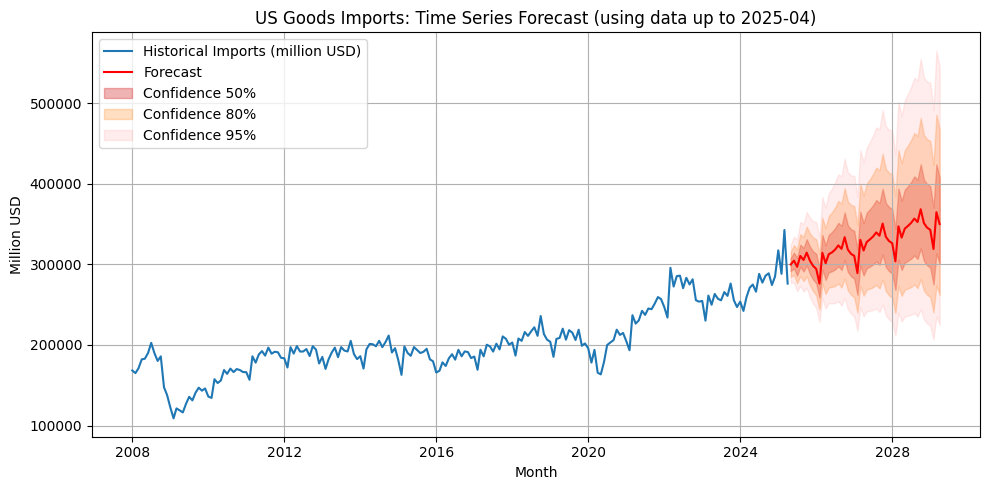

In [70]:
csv_path = r"..\..\data\processed\Q4_IMPTOTUS_ALL.csv"
out_path = r"..\..\data\processed\Q4_IMPTOTUS_forecast_without_tariff_48m.csv"

# 1) 加载数据与ADF检验（对log后的非缺失部分）
y = load_data(csv_path)
y_log = np.log(y.dropna())
adf_stat, adf_p, *_ = adfuller(y_log)
print(f'ADF统计量: {adf_stat:.4f}  p值: {adf_p:.6f}')

# 2) 选择并拟合最优SARIMA
best_cfg, best_model, best_aic = choose_sarima(y_log)
print(f'最佳模型: {best_cfg}  AIC: {best_aic:.2f}')

# 3) 预测未来48个月（原尺度），并设置索引名
fc_df = forecast_48(best_model)
fc_df.index.name = 'Month'

# 4) 保存CSV到 processed
fc_df.to_csv(out_path)
print('预测前5条:')
print(fc_df.head())
print(f'CSV已保存: {out_path}')

# 5) 绘图（英文，5秒自动关闭）
plot_result(y, fc_df)

我们现在得到了baseline的预测值, 接下来考虑的就是如何解决关税冲击的这个问题了, 我们首先关注2018年的关税战, 然后将得出的线性的关税模型应用到2025年5月之后的预测中



C:\Users\danchen\AppData\Local\Temp\ipykernel_47100\282946707.py:60: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
e:\RESEARCH\APMCM\Math_Modeling_APMCM\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


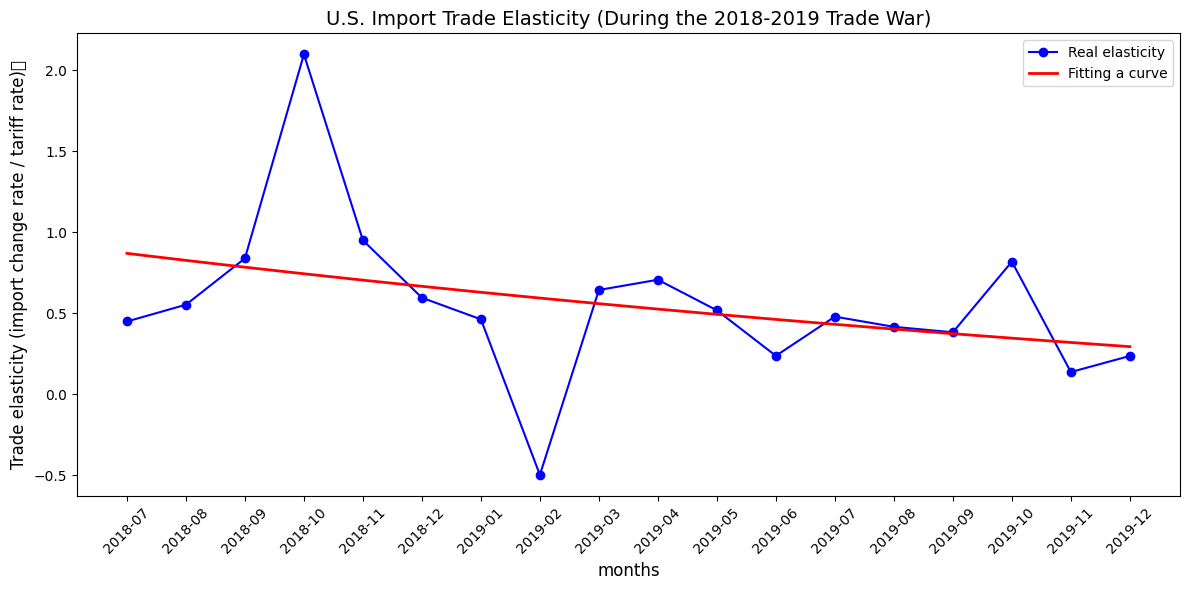

基于历史数据训练的参数: 短期弹性=0.91, 长期弹性=-0.49, 调整速度=0.03
真实弹性序列：
                       月份  关税幅度(%)   真实弹性
observation_date                         
2018-07-01        2018-07       25  0.449
2018-08-01        2018-08       25  0.553
2018-09-01        2018-09       10  0.839
2018-10-01        2018-10       10  2.097
2018-11-01        2018-11       10  0.950
2018-12-01        2018-12       10  0.596
2019-01-01        2019-01       10  0.462
2019-02-01        2019-02       10 -0.497
2019-03-01        2019-03       10  0.643
2019-04-01        2019-04       10  0.707
2019-05-01        2019-05       25  0.518
2019-06-01        2019-06       25  0.237
2019-07-01        2019-07       25  0.479
2019-08-01        2019-08       25  0.416
2019-09-01        2019-09       15  0.382
2019-10-01        2019-10       15  0.818
2019-11-01        2019-11       15  0.137
2019-12-01        2019-12       15  0.236


In [71]:
from scipy.optimize import curve_fit

# -------------------------- 1. 数据读取与预处理（修正日期索引）--------------------------
df_imports = pd.read_csv(r'..\..\data\raw\Q4\IMPTOTUS.csv')
# 关键：将日期转为datetime类型（必须执行，否则日期切片失效）
df_imports['observation_date'] = pd.to_datetime(df_imports['observation_date'])
df_imports.set_index('observation_date', inplace=True)

# 筛选贸易战期间数据（2018-07 到 2019-12，与关税月份完全对齐）
df_imports_trade_war = df_imports.loc["2018-07-01":"2019-12-01"].copy()
# 检查是否有18个月份（与tariff_rates数量一致），删除缺失值
df_imports_trade_war = df_imports_trade_war.dropna()
assert len(df_imports_trade_war) == 18, f"数据量不对，应为18个月，实际为{len(df_imports_trade_war)}个月"

# -------------------------- 2. 关税数据定义（保持不变，确保与月份对齐）--------------------------
tariff_rates = np.array([
    25, 25, 10, 10, 10, 10, 10, 10, 10, 10, 25, 25, 25, 25, 15, 15, 15, 15
])
months = np.array([
    '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12',
    '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06',
    '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12'
])
# 定义“关税生效后的第n个月”（拟合模型需要数值型自变量）
months_index = np.arange(1, len(months)+1)  # [1,2,...,18]

# -------------------------- 3. 修正弹性计算逻辑（关键！）--------------------------
# 步骤1：计算“贸易量变化率”（相对于贸易战前的基准值，这里用2017年平均进口额作为基准）
baseline_2017 = df_imports.loc["2017-01-01":"2017-12-01", "IMPTOTUS"].mean()  # 2017年平均进口额（基准）
df_imports_trade_war['import_growth_rate'] = (df_imports_trade_war['IMPTOTUS'] - baseline_2017) / baseline_2017  # 进口变化率（%）

# 步骤2：计算真实弹性 = 进口变化率 / 关税幅度（关税幅度需转为小数，如25%→0.25）
real_elasticities = df_imports_trade_war['import_growth_rate'] / (tariff_rates / 100)
# 弹性含义：关税每加征1%，进口量变化多少%（负值=进口下降）

# -------------------------- 4. 模型拟合与可视化（修正变量未定义问题）--------------------------
# 定义衰减模型（保持不变）
def decay_func(t, e_short, e_long, speed):
    return e_long - (e_long - e_short) * np.exp(-speed * t)

# 拟合模型（用数值型的months_index作为自变量，设置合理初始值）
popt, pcov = curve_fit(
    decay_func, 
    xdata=months_index, 
    ydata=real_elasticities,
    p0=[real_elasticities.iloc[0], real_elasticities.iloc[-1], 0.1],  # 初始值：短期弹性=第一个观测值，长期弹性=最后一个观测值
    maxfev=5000  # 增加迭代次数，避免拟合失败
)
fitted_e_short, fitted_e_long, fitted_speed = popt

# 绘制真实弹性与拟合曲线
plt.figure(figsize=(12, 6))
plt.plot(months_index, real_elasticities, 'o-', label='Real elasticity', color='blue')
plt.plot(months_index, decay_func(months_index, *popt), '-', label='Fitting a curve', color='red', linewidth=2)
plt.xticks(months_index, months, rotation=45)  # 旋转x轴标签，避免拥挤
plt.xlabel('months', fontsize=12)
plt.ylabel('Trade elasticity (import change rate / tariff rate)）', fontsize=12)
plt.title('U.S. Import Trade Elasticity (During the 2018-2019 Trade War)', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------- 5. 输出结果与保存数据--------------------------
print(f"基于历史数据训练的参数: 短期弹性={fitted_e_short:.2f}, 长期弹性={fitted_e_long:.2f}, 调整速度={fitted_speed:.2f}")
print("真实弹性序列：")
print(pd.DataFrame({'月份': months, '关税幅度(%)': tariff_rates, '真实弹性': real_elasticities.round(3)}))

# 保存处理后的数据（避免覆盖，用不同文件名）
df_imports_trade_war['True elasticity'] = real_elasticities
df_imports_trade_war.to_csv(r'..\..\data\processed\Q4_IMPTOTUS_trade_war_elasticity.csv', index=True)

接下来我们尝试将计算出来的弹性系数应用到2025年5月之后的预测中

In [72]:
import pandas as pd
import matplotlib.pyplot as plt

df_imports = pd.read_csv(r'..\..\data\raw\Q4\IMPTOTUS.csv')
df_imports.head()



# df_imports['IMPTOTUS_DIFF'] = df_imports['IMPTOTUS'].astype(float).diff()
# plt.plot(df_imports['observation_date'],df_imports['IMPTOTUS_DIFF'])
# plt.xlabel('Month')
# plt.title('Imports of United States')
# plt.show()
# print(df_imports['IMPTOTUS_DIFF'].mean(), df_imports['IMPTOTUS_DIFF'].std())

# df_imports['IMPTOTUS_std']= df_imports['IMPTOTUS_DIFF'].astype(float).rolling(window=5,min_periods=1).std()
# plt.plot(df_imports['observation_date'],df_imports['IMPTOTUS_std'])
# plt.xlabel('Month')
# plt.title('Imports of United States')
# plt.show()

,observation_date,IMPTOTUS
0,2008-01-01,168350.2
1,2008-02-01,165069.7
2,2008-03-01,171194.0
3,2008-04-01,182115.1
4,2008-05-01,182956.3


(开始尝试一下最简单的时间序列分析)这个直接使用AI编程就行了

尝试探索一下第一次关税战的对进口额的影响:
1. 绘制一下2017-2020年的进口额变化趋势, 简单计算一些统计量
2. 尝试获得关税幅度的数据


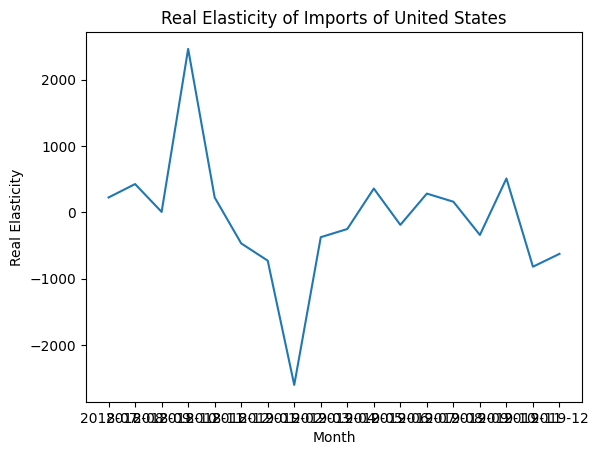

observation_date
2018-07-01     224.062477
2018-08-01     425.772106
2018-09-01       6.481169
2018-10-01    2460.504973
2018-11-01     224.037157
2018-12-01    -467.492549
2019-01-01    -727.192691
2019-02-01   -2598.513012
2019-03-01    -374.161629
2019-04-01    -251.051983
2019-05-01     358.197943
2019-06-01    -188.843326
2019-07-01     282.339364
2019-08-01     159.726149
2019-09-01    -340.248542
2019-10-01     509.896806
2019-11-01    -818.540517
2019-12-01    -625.020529
Name: IMPTOTUS_DIFF_from_head, dtype: float64
基于历史数据训练的参数: 短期弹性=943.12, 长期弹性=-342.02, 调整速度=0.25


C:\Users\danchen\AppData\Local\Temp\ipykernel_47100\746617268.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  popt, pcov = curve_fit(decay_func, months_index, real_elasticities, p0=[real_elasticities[0], real_elasticities[-1], 0.1])


In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


df_imports = pd.read_csv(r'..\..\data\raw\Q4\IMPTOTUS.csv')
# df_imports['observation_date'] = pd.to_datetime(df_imports['observation_date'])
df_imports.set_index('observation_date', inplace=True)
df_imports.head()

# df_imports_2017_2020=df_imports.loc["2017-01-01":"2020-12-01"].copy()
# df_imports_2017_2020.head()
# df_imports_2017_2020.to_csv(r'..\..\data\processed\Q4_IMPTOTUS_2017_2020.csv', index=True)


# plt.plot(df_imports_2017_2020.index,df_imports_2017_2020['IMPTOTUS'])
# plt.xlabel('Month')
# plt.ylabel('Imports(in billions of US dollars)')
# plt.title('Imports of United States')
# plt.show()
# print(df_imports['IMPTOTUS'].mean(), df_imports['IMPTOTUS'].std())


# df_imports_2017_2020['IMPTOTUS_DIFF'] = df_imports_2017_2020['IMPTOTUS'].diff()
# plt.plot(df_imports_2017_2020.index,df_imports_2017_2020['IMPTOTUS_DIFF'])
# plt.xlabel('Month')
# plt.ylabel('Imports diff (in billions of US dollars)')
# plt.title('Imports of United States')
# plt.show()
# print(df_imports_2017_2020['IMPTOTUS_DIFF'].mean(), df_imports_2017_2020['IMPTOTUS_DIFF'].std())

tariff_rates = np.array([
    25,   # 2018-07：340亿美元商品加征25%
    25,   # 2018-08：新增160亿美元商品加征25%
    10,   # 2018-09：2000亿美元商品加征10%
    10,   # 2018-10
    10,   # 2018-11
    10,   # 2018-12
    10,   # 2019-01
    10,   # 2019-02
    10,   # 2019-03
    10,   # 2019-04
    25,   # 2019-05：2000亿美元商品关税提高至25%
    25,   # 2019-06
    25,   # 2019-07
    25,   # 2019-08
    15,   # 2019-09：新增1120亿美元商品加征15%
    15,   # 2019-10
    15,   # 2019-11
    15    # 2019-12：原计划新增1600亿美元商品加征15%
])

# 对应的月份标签
months = np.array([
    '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12',
    '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06',
    '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12'
])
# months_index = np.array([
#     1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18
# ])

df_imports_trade_war=df_imports.loc["2018-06-01":"2019-12-01"].copy()
df_imports_trade_war.head()
df_imports_trade_war.tail()
# df_imports_trade_war.to_csv(r'..\..\data\processed\Q4_IMPTOTUS_2017_2020.csv', index=True)

df_imports_trade_war['IMPTOTUS_DIFF'] = df_imports_trade_war['IMPTOTUS'].diff()
df_imports_trade_war.head()
df_imports_trade_war.tail()

df_imports_trade_war['IMPTOTUS_DIFF_from_head'] = df_imports_trade_war['IMPTOTUS_DIFF'].cumsum()
df_imports_trade_war.head()
df_imports_trade_war.tail()
df_imports_trade_war.drop(index='2018-06-01', inplace=True)
# plt.plot(df_imports_trade_war.index,df_imports_trade_war['IMPTOTUS_DIFF'])
# plt.xlabel('Month')
# plt.ylabel('Imports (in billions of US dollars)')
# plt.title('Imports of United States')
# plt.show()
# print(df_imports_trade_war['IMPTOTUS_DIFF'].mean(), df_imports_trade_war['IMPTOTUS_DIFF'].std())

real_elasticities=df_imports_trade_war['IMPTOTUS_DIFF_from_head']/tariff_rates
plt.plot(months,real_elasticities)
plt.xlabel('Month')
plt.ylabel('Real Elasticity')
plt.title('Real Elasticity of Imports of United States')
plt.show()
print(real_elasticities)

# 定义衰减方程
def decay_func(t, e_short, e_long, speed):
    return e_long - (e_long - e_short) * np.exp(-speed * t)

# curve_fit：根据观测数据（months, real_elasticities），找到使模型最贴近数据的参数
popt, pcov = curve_fit(decay_func, months_index, real_elasticities, p0=[real_elasticities[0], real_elasticities[-1], 0.1])

# 获取“科学”的参数
fitted_e_short, fitted_e_long, fitted_speed = popt

print(f"基于历史数据训练的参数: 短期弹性={fitted_e_short:.2f}, 长期弹性={fitted_e_long:.2f}, 调整速度={fitted_speed:.2f}")

# df_imports['IMPTOTUS_DIFF_STD'] = df_imports.rolling(window=12,min_periods=1).std()
# plt.plot(df_imports['observation_date'],df_imports['IMPTOTUS_DIFF_STD'])
# plt.xlabel('Month')
# plt.ylabel('Imports diff STD (in billions of US dollars)')
# plt.title('Imports of United States')
# plt.show()

尝试一下修改逻辑的代码